In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [36]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                                        ])


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


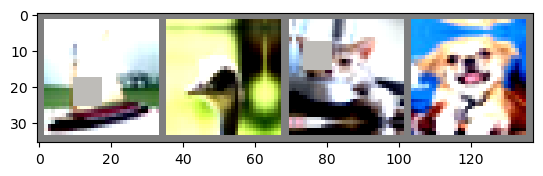

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, 
                out_channels=32, 
                kernel_size=(3,3), 
                padding=2, 
                stride=2, 
                dilation=2, 
                bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, 
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding=2, 
                      dilation=2,
                      stride=2, 
                      bias=False),
        ) # output_size = 8/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]          18,432
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

You should consider upgrading via the 'I:\Installs\python.exe -m pip install --upgrade pip' command.


In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]

Loss=1.5291692018508911 Batch_id=97 Accuracy=33.20: 100%|██████████| 98/98 [00:12<00:00,  7.92it/s]



Test set: Average loss: 1.5387, Accuracy: 4347/10000 (43.47%)

EPOCH: 1


Loss=1.234505295753479 Batch_id=97 Accuracy=48.55: 100%|██████████| 98/98 [00:12<00:00,  7.86it/s] 



Test set: Average loss: 1.2523, Accuracy: 5497/10000 (54.97%)

EPOCH: 2


Loss=1.034727692604065 Batch_id=97 Accuracy=56.00: 100%|██████████| 98/98 [00:12<00:00,  8.02it/s] 



Test set: Average loss: 1.0585, Accuracy: 6227/10000 (62.27%)

EPOCH: 3


Loss=1.0637298822402954 Batch_id=97 Accuracy=60.66: 100%|██████████| 98/98 [00:11<00:00,  8.70it/s]



Test set: Average loss: 0.9732, Accuracy: 6558/10000 (65.58%)

EPOCH: 4


Loss=1.0076223611831665 Batch_id=97 Accuracy=63.53: 100%|██████████| 98/98 [00:11<00:00,  8.26it/s]



Test set: Average loss: 0.9777, Accuracy: 6574/10000 (65.74%)

EPOCH: 5


Loss=0.8838014006614685 Batch_id=97 Accuracy=66.38: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s]



Test set: Average loss: 0.9033, Accuracy: 6772/10000 (67.72%)

EPOCH: 6


Loss=0.8126224279403687 Batch_id=97 Accuracy=68.18: 100%|██████████| 98/98 [00:11<00:00,  8.50it/s]



Test set: Average loss: 0.7953, Accuracy: 7204/10000 (72.04%)

EPOCH: 7


Loss=0.8742702007293701 Batch_id=97 Accuracy=69.89: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]



Test set: Average loss: 0.7648, Accuracy: 7348/10000 (73.48%)

EPOCH: 8


Loss=0.6765643358230591 Batch_id=97 Accuracy=71.28: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]



Test set: Average loss: 0.7035, Accuracy: 7528/10000 (75.28%)

EPOCH: 9


Loss=0.7942789793014526 Batch_id=97 Accuracy=72.76: 100%|██████████| 98/98 [00:11<00:00,  8.87it/s]



Test set: Average loss: 0.6854, Accuracy: 7583/10000 (75.83%)

EPOCH: 10


Loss=0.7274999618530273 Batch_id=97 Accuracy=73.78: 100%|██████████| 98/98 [00:11<00:00,  8.62it/s]



Test set: Average loss: 0.6622, Accuracy: 7721/10000 (77.21%)

EPOCH: 11


Loss=0.6248548030853271 Batch_id=97 Accuracy=74.65: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]



Test set: Average loss: 0.6372, Accuracy: 7768/10000 (77.68%)

EPOCH: 12


Loss=0.637121319770813 Batch_id=97 Accuracy=75.27: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s] 



Test set: Average loss: 0.6128, Accuracy: 7874/10000 (78.74%)

EPOCH: 13


Loss=0.6304006576538086 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:11<00:00,  8.48it/s]



Test set: Average loss: 0.6035, Accuracy: 7940/10000 (79.40%)

EPOCH: 14


Loss=0.6427037119865417 Batch_id=97 Accuracy=76.74: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]



Test set: Average loss: 0.5862, Accuracy: 7998/10000 (79.98%)

EPOCH: 15


Loss=0.6447756886482239 Batch_id=97 Accuracy=77.28: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]



Test set: Average loss: 0.5652, Accuracy: 8020/10000 (80.20%)

EPOCH: 16


Loss=0.7058292627334595 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s] 



Test set: Average loss: 0.5473, Accuracy: 8129/10000 (81.29%)

EPOCH: 17


Loss=0.6535874009132385 Batch_id=97 Accuracy=78.21: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]



Test set: Average loss: 0.5358, Accuracy: 8161/10000 (81.61%)

EPOCH: 18


Loss=0.5560546517372131 Batch_id=97 Accuracy=78.60: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s]



Test set: Average loss: 0.5352, Accuracy: 8167/10000 (81.67%)

EPOCH: 19


Loss=0.5922632217407227 Batch_id=97 Accuracy=78.93: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s] 



Test set: Average loss: 0.5420, Accuracy: 8198/10000 (81.98%)

EPOCH: 20


Loss=0.6108404994010925 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s] 



Test set: Average loss: 0.5084, Accuracy: 8292/10000 (82.92%)

EPOCH: 21


Loss=0.569460928440094 Batch_id=97 Accuracy=80.19: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]  



Test set: Average loss: 0.5125, Accuracy: 8256/10000 (82.56%)

EPOCH: 22


Loss=0.5743367671966553 Batch_id=97 Accuracy=80.17: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s] 



Test set: Average loss: 0.5039, Accuracy: 8268/10000 (82.68%)

EPOCH: 23


Loss=0.5277301669120789 Batch_id=97 Accuracy=80.74: 100%|██████████| 98/98 [00:11<00:00,  8.61it/s] 



Test set: Average loss: 0.4966, Accuracy: 8296/10000 (82.96%)

EPOCH: 24


Loss=0.49899259209632874 Batch_id=97 Accuracy=81.01: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s]



Test set: Average loss: 0.4929, Accuracy: 8304/10000 (83.04%)

EPOCH: 25


Loss=0.5671839118003845 Batch_id=97 Accuracy=81.45: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s] 



Test set: Average loss: 0.4593, Accuracy: 8437/10000 (84.37%)

EPOCH: 26


Loss=0.554086446762085 Batch_id=97 Accuracy=81.46: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]  



Test set: Average loss: 0.4917, Accuracy: 8353/10000 (83.53%)

EPOCH: 27


Loss=0.5977595448493958 Batch_id=97 Accuracy=81.83: 100%|██████████| 98/98 [00:13<00:00,  7.12it/s] 



Test set: Average loss: 0.4588, Accuracy: 8414/10000 (84.14%)

EPOCH: 28


Loss=0.49410611391067505 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.4680, Accuracy: 8416/10000 (84.16%)

EPOCH: 29


Loss=0.45043227076530457 Batch_id=97 Accuracy=82.35: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 0.4526, Accuracy: 8443/10000 (84.43%)

EPOCH: 30


Loss=0.4722309708595276 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s] 



Test set: Average loss: 0.4506, Accuracy: 8453/10000 (84.53%)

EPOCH: 31


Loss=0.5275596976280212 Batch_id=97 Accuracy=82.44: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s] 



Test set: Average loss: 0.4629, Accuracy: 8421/10000 (84.21%)

EPOCH: 32


Loss=0.5215408205986023 Batch_id=97 Accuracy=82.80: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s] 



Test set: Average loss: 0.4357, Accuracy: 8509/10000 (85.09%)

EPOCH: 33


Loss=0.44231411814689636 Batch_id=16 Accuracy=82.95:  17%|█▋        | 17/98 [00:02<00:12,  6.71it/s]


KeyboardInterrupt: 